In [2]:
import zarr
import sys
import allel
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
#import matplotlib_venn as venn
import seaborn as sns

## build zarr from merged vcf

In [62]:
# def build_sample_zarr(input, output):
#     allel.vcf_to_zarr(
#         input=input,
#         output=output,
#         compressor=zarr.Blosc(cname='zstd', clevel=5, shuffle=0),
#         overwrite=True,
#         fields=['*'],
#         alt_number=3,
#         chunk_length=2**18,
#         log=sys.stdout,
#     )

In [63]:
input_vcf = '/home/chris/Universal_ref/variation/merged.vcf'
output_path = '../data/merged.zarr'

In [64]:
# build_sample_zarr(input_vcf, output_path)

## check zarr

In [14]:
callset = zarr.open_group('merged.zarr/', mode='r')
callset

<zarr.hierarchy.Group '/' read-only>

In [15]:
list(callset['calldata'].keys())

['AD', 'DP', 'GQ', 'GT', 'PL']

In [16]:
callset['calldata/GT'][:].shape

(266548, 121, 2)

In [17]:
gt = allel.GenotypeArray(callset['calldata/GT'][:])

In [18]:
gt

<GenotypeArray shape=(266548, 121, 2) dtype=int8>
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. 0/0 ./.
...
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.

In [19]:
chrom = callset['variants/CHROM']
chrom[:]

array(['chr2L.1', 'chr2L.1', 'chr2L.1', ..., 'Pf_M76611', 'Pf_M76611',
       'Pf_M76611'], dtype=object)

## get meta data from csv

In [20]:
df_meta = pd.read_csv('1175-VO-KH-STLAURENT-S01-samples.csv', sep=',')
df_meta.columns, len(df_meta)

(Index(['ROMA_ID', 'Sanger_ID', 'Public_name', 'Sample_type', 'Status',
        'External_ID', 'Species_complex', 'Species', 'Collection_date',
        'Collection_time', 'Collection_location', 'GPS', 'Collection_context',
        'Collection_method', 'Sex', 'Specimen_type'],
       dtype='object'), 159)

In [21]:
#keep only sequenced
df_meta_seq = df_meta[df_meta.Status == 'sequenced']
len(df_meta_seq)

128

In [22]:
all_128_samples = np.asarray(df_meta_seq.ROMA_ID)

## setup data for distance analysis

1. remove the Pf gene positions 
2. look as missingness per variant and per sample, we only really want to keep informative positions/samples
3. what happens to missing data if we leave it there then calculate distance?

In [23]:
gt.shape

(266548, 121, 2)

In [24]:
#1. remove Pf gene
pfbool = chrom[:]!='Pf_M76611'
gt_nopf = gt.compress(pfbool)
gt_nopf.shape

(260581, 121, 2)

In [25]:
#2. look at per sample missingness
ismiss = gt_nopf.is_missing()
persam_ismiss = np.sum(ismiss, axis=0)
persam_ismiss.shape

(121,)

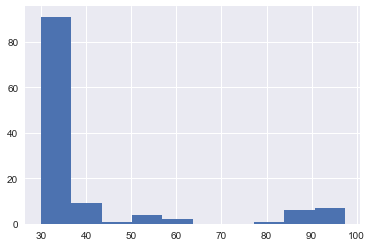

In [26]:
#plot
persam_rate = persam_ismiss/260581*100
plt.hist(persam_rate);

In [27]:
#eyeballing plot - keep samples with <40% missingness - loose 25 samples
persam_bool = persam_rate <= 40
np.count_nonzero(persam_bool)

96

In [28]:
#keep track of the samples we have left
gud_samples = np.asarray(callset['samples']).compress(persam_bool)
len(gud_samples)

96

In [29]:
#compress genotype array to keep just gud samples
gt_gudsam = gt_nopf.compress(persam_bool, axis=1)
gt_gudsam.shape

(260581, 96, 2)

In [30]:
#compress meta data to just keep the info for the gud samples
gudsam_bool = np.in1d(all_128_samples, gud_samples)
df_meta_gud = df_meta_seq[gudsam_bool]
df_meta_gud.shape

(96, 16)

In [31]:
#3. look at per var missingness
ismissvar = gt_gudsam.is_missing()
pervar_ismiss = np.sum(ismissvar, axis=1)
pervar_ismiss.shape

(260581,)

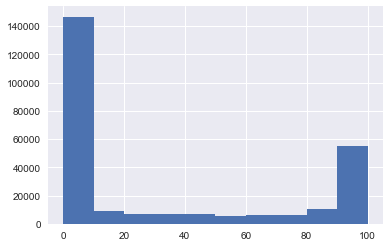

In [32]:
pervar_rate = pervar_ismiss/96*100
plt.hist(pervar_rate);

In [33]:
#how many var do we have with 0 missingness?
full = pervar_rate == 0
np.count_nonzero(full)

97083

## let's look at the dendrogram using just the 0% missing variants

In [34]:
#if we just use the 0 missingness sites what happens?
gt_nomiss = gt_gudsam.compress(full)
gt_nomiss

<GenotypeArray shape=(97083, 96, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [35]:
#measure distance and cluster samples
d = allel.stats.pairwise_distance(gt_nomiss.to_n_alt(), metric='cityblock')
z = scipy.cluster.hierarchy.linkage(d, method='average')

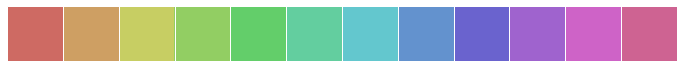

In [57]:
#palette
palette = sns.color_palette('hls', n_colors=12, desat=0.8)
sns.palplot(palette);

In [37]:
# #use names and palette to define plotting colours
# colors = {
#     'An. annularis group': palette[0],
#     '': palette[1],
#     'An. hyrcanus group': palette[2],
#     'An. maculatus group': palette[3],
#     'An. kochi group': palette[4],
#     'An. funestus group': palette[5],
#     'An. barbirostris group': palette[6],
#     'An. dirus complex': palette[7]
# }

# labels = {
#     'An. annularis group': 'An. annularis group',
#     '': 'other',
#     'An. hyrcanus group': 'An. hyrcanus group',
#     'An. maculatus group':'An. maculatus group',
#     'An. kochi group': 'An. kochi group',
#     'An. funestus group': 'An. funestus group',
#     'An. barbirostris group': 'An. barbirostris group',
#     'An. dirus complex':'An. dirus complex'
# }

In [59]:
#use names and palette to define plotting colours

colors = {
    'An. annularis group': palette[0],
    'An. hyrcanus group': palette[3],
    'An. maculatus group': palette[4],
    'An. kochi group': palette[5],
    'An. funestus group': palette[6],
    'An. barbirostris group': palette[7],
    'An. dirus complex': palette[9],
    '': palette[10],
    'An. gambiae': 'r',
    'An. arabiensis':'b',
    'An. funestus': 'k'
}


labels = {
    'An. annularis group': 'An. annularis group',
    'An. hyrcanus group': 'An. hyrcanus group',
    'An. maculatus group':'An. maculatus group',
    'An. kochi group': 'An. kochi group',
    'An. funestus group': 'An. funestus group',
    'An. barbirostris group': 'An. barbirostris group',
    'An. dirus complex':'An. dirus complex',
    '':'other'
}

In [60]:
#fix the df NaNs
df_meta_gud = df_meta_gud.fillna(value='')
#names so we can add labels etc
vbs = np.asarray(df_meta_gud.ROMA_ID)
vsc = np.asarray(df_meta_gud.Species_complex)
vsp = np.asarray(df_meta_gud.Species)

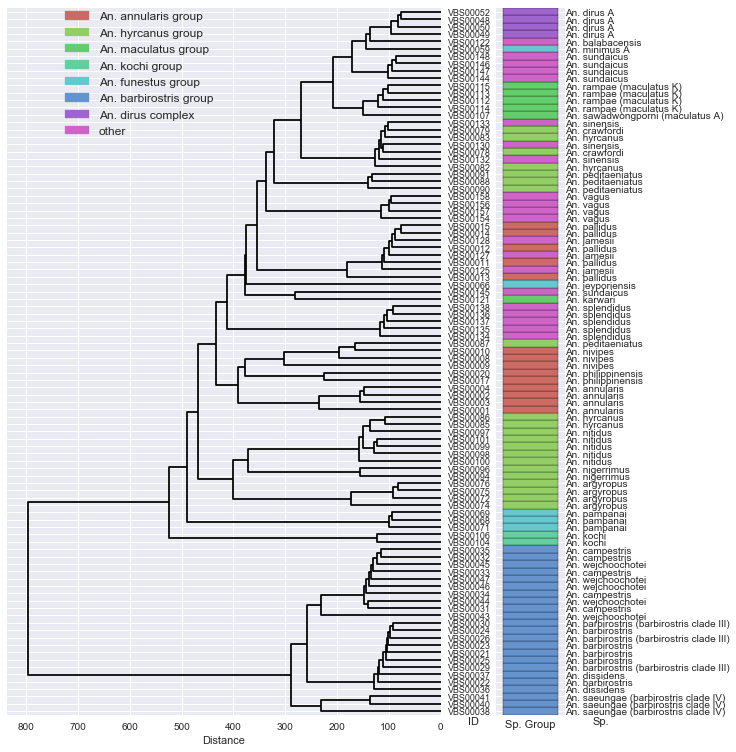

In [41]:
#plot
fig = plt.figure(figsize=(10, 13), )
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=(2.5, 0.4), wspace=0.22)

#dendro
ax = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax, left=True, right=True, bottom=False)
r = scipy.cluster.hierarchy.dendrogram(
    z, no_labels=False, count_sort=True, 
    color_threshold=0, labels=vbs,
    above_threshold_color='k',
    ax=ax, leaf_font_size=9, orientation='left')
ax.set_xlabel('Distance', size=11)
#legend
handles = [mpl.patches.Patch(color=colors[p], label=labels[p]) for p in list(colors.keys())]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.5, 1.011), ncol=1, fontsize=12)

#colour bar
ax = fig.add_subplot(gs[0, 1])
sns.despine(ax=ax, left=True, right=True, bottom=True)
#get the clustered order of samples
sp_com = vsc[r['leaves']]
#make list of species complex colours to match the clustered sample order
sp_com_colors = [colors[p] for p in sp_com]
#plot
ax.bar(left=np.full((len(vbs)), 0.5), height=np.full((96), 1), bottom=np.asarray(range(0,96)), color=sp_com_colors, edgecolor='k')
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_ylim(0,96)
ax.set_xlabel('Sp. Group', size=11)
ax.set_yticks(np.arange(96)+0.5)
ax.set_yticklabels(vsp[r['leaves']], ha='left', position=(1.1,2), fontsize=10)
ax.tick_params(length=0.0)
ax.text(-0.4, -1.3, 'ID', fontsize=11)
ax.text(1.4, -1.3, 'Sp.', fontsize=11)

fig.savefig('../uniref_nomissing_nocrapsamp.jpeg', jpeg_quality=100, bbox_inches='tight');

## remove the WGA samples too

In [42]:
#remove the WGA samples too?
isitnotWGA = df_meta_gud.Sample_type == "Genomic DNA"
np.count_nonzero(isitnotWGA)

83

In [43]:
gt_nowga = gt_nomiss.compress(isitnotWGA, axis=1)
gt_nowga

<GenotypeArray shape=(97083, 83, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [44]:
df_meta_nowga = df_meta_gud[isitnotWGA]
df_meta_nowga.shape

(83, 16)

In [45]:
#names so we can add labels etc
vbs = np.asarray(df_meta_nowga.ROMA_ID)
vsc = np.asarray(df_meta_nowga.Species_complex)
vsp = np.asarray(df_meta_nowga.Species)

In [46]:
#measure distance and cluster samples
d = allel.stats.pairwise_distance(gt_nowga.to_n_alt(), metric='cityblock')
z = scipy.cluster.hierarchy.linkage(d, method='average')

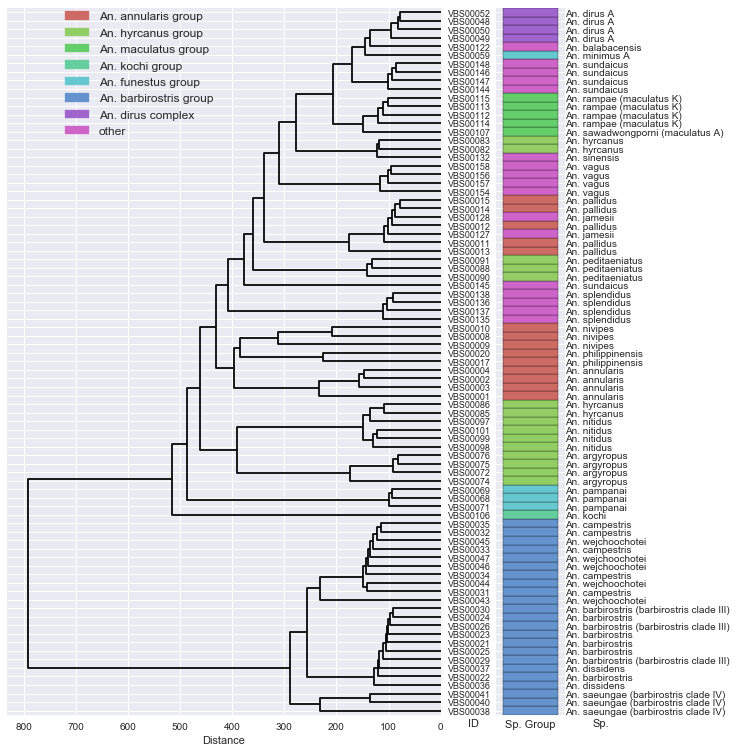

In [48]:
#plot
fig = plt.figure(figsize=(10, 13), )
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=(2.5, 0.4), wspace=0.22)

#dendro
ax = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax, left=True, right=True, bottom=False)
r = scipy.cluster.hierarchy.dendrogram(
    z, no_labels=False, count_sort=True, 
    color_threshold=0, labels=vbs,
    above_threshold_color='k',
    ax=ax, leaf_font_size=9, orientation='left')
ax.set_xlabel('Distance', size=11)
#legend
handles = [mpl.patches.Patch(color=colors[p], label=labels[p]) for p in list(colors.keys())]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.5, 1.011), ncol=1, fontsize=12)

#colour bar
ax = fig.add_subplot(gs[0, 1])
sns.despine(ax=ax, left=True, right=True, bottom=True)
#get the clustered order of samples
sp_com = vsc[r['leaves']]
#make list of species complex colours to match the clustered sample order
sp_com_colors = [colors[p] for p in sp_com]
#plot
ax.bar(left=np.full((len(vbs)), 0.5), height=np.full((len(vbs)), 1), bottom=np.asarray(range(0,len(vbs))), color=sp_com_colors, edgecolor='k')
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_ylim(0,len(vbs))
ax.set_xlabel('Sp. Group', size=11)
ax.set_yticks(np.arange(len(vbs))+0.5)
ax.set_yticklabels(vsp[r['leaves']], ha='left', position=(1.1,2), fontsize=10)
ax.tick_params(length=0.0)
ax.text(-0.4, -1.3, 'ID', fontsize=11)
ax.text(1.4, -1.3, 'Sp.', fontsize=11)

fig.savefig('../uniref_nomissing_nocrapsamp_noWGA.jpeg', jpeg_quality=100, bbox_inches='tight');

In [49]:
#use different metrics

#these seem to generate the cleanest clusters, using method=average is less good
d = allel.stats.pairwise_distance(gt_nowga.to_n_alt(), metric='cityblock')
z = scipy.cluster.hierarchy.linkage(d, method='complete')

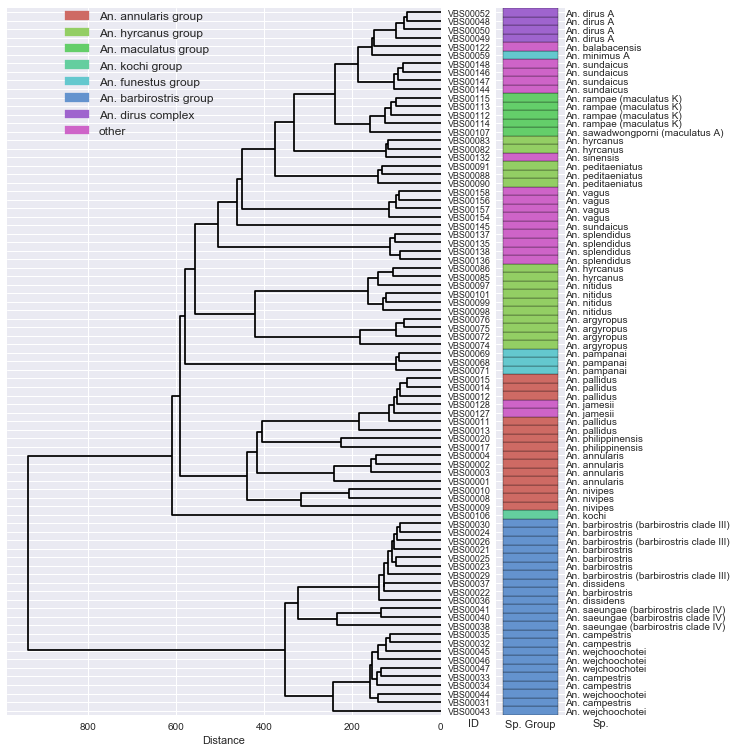

In [51]:
#plot
fig = plt.figure(figsize=(10, 13), )
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=(2.5, 0.4), wspace=0.22)

#dendro
ax = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax, left=True, right=True, bottom=False)
r = scipy.cluster.hierarchy.dendrogram(
    z, no_labels=False, count_sort=True, 
    color_threshold=0, labels=vbs,
    above_threshold_color='k',
    ax=ax, leaf_font_size=9, orientation='left')
ax.set_xlabel('Distance', size=11)
#legend
handles = [mpl.patches.Patch(color=colors[p], label=labels[p]) for p in list(colors.keys())]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.5, 1.011), ncol=1, fontsize=12)

#colour bar
ax = fig.add_subplot(gs[0, 1])
sns.despine(ax=ax, left=True, right=True, bottom=True)
#get the clustered order of samples
sp_com = vsc[r['leaves']]
#make list of species complex colours to match the clustered sample order
sp_com_colors = [colors[p] for p in sp_com]
#plot
ax.bar(left=np.full((len(vbs)), 0.5), height=np.full((len(vbs)), 1), bottom=np.asarray(range(0,len(vbs))), color=sp_com_colors, edgecolor='k')
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_ylim(0,len(vbs))
ax.set_xlabel('Sp. Group', size=11)
ax.set_yticks(np.arange(len(vbs))+0.5)
ax.set_yticklabels(vsp[r['leaves']], ha='left', position=(1.1,2), fontsize=10)
ax.tick_params(length=0.0)
ax.text(-0.4, -1.3, 'ID', fontsize=11)
ax.text(1.4, -1.3, 'Sp.', fontsize=11)

fig.savefig('../uniref_nomissing_nocrapsamp_noWGA_spam.jpeg', jpeg_quality=100, bbox_inches='tight');

In [52]:
#interestingly is does appear to affect the clustering...

## use all the variants - what happens to missing data?

In [53]:
#take the all var-gud sample genotype, remove the WGA samples then cluster
gt_gudsam

<GenotypeArray shape=(260581, 96, 2) dtype=int8>
./. ./. ./. ./. ./. ... 0/0 ./. ./. ./. ./.
./. ./. ./. ./. ./. ... 0/0 ./. ./. ./. ./.
./. ./. ./. ./. ./. ... 0/0 ./. ./. 0/0 ./.
...
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.

In [54]:
gt_al = gt_gudsam.compress(isitnotWGA, axis=1)
gt_al

<GenotypeArray shape=(260581, 83, 2) dtype=int8>
./. ./. ./. ./. ./. ... 0/0 ./. ./. ./. ./.
./. ./. ./. ./. ./. ... 0/0 ./. ./. ./. ./.
./. ./. ./. ./. ./. ... 0/0 ./. ./. 0/0 ./.
...
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.

In [55]:
#measure distance and cluster samples
d = allel.stats.pairwise_distance(gt_al.to_n_alt(), metric='cityblock')
z = scipy.cluster.hierarchy.linkage(d, method='complete')

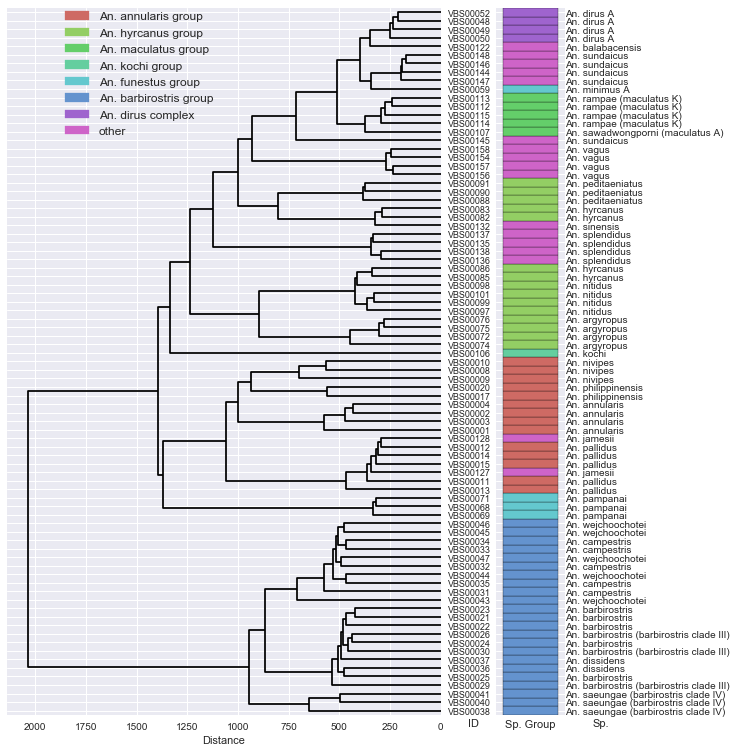

In [56]:
#plot
fig = plt.figure(figsize=(10, 13), )
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=(2.5, 0.4), wspace=0.22)

#dendro
ax = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax, left=True, right=True, bottom=False)
r = scipy.cluster.hierarchy.dendrogram(
    z, no_labels=False, count_sort=True, 
    color_threshold=0, labels=vbs,
    above_threshold_color='k',
    ax=ax, leaf_font_size=9, orientation='left')
ax.set_xlabel('Distance', size=11)
#legend
handles = [mpl.patches.Patch(color=colors[p], label=labels[p]) for p in list(colors.keys())]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.5, 1.011), ncol=1, fontsize=12)

#colour bar
ax = fig.add_subplot(gs[0, 1])
sns.despine(ax=ax, left=True, right=True, bottom=True)
#get the clustered order of samples
sp_com = vsc[r['leaves']]
#make list of species complex colours to match the clustered sample order
sp_com_colors = [colors[p] for p in sp_com]
#plot
ax.bar(left=np.full((len(vbs)), 0.5), height=np.full((len(vbs)), 1), bottom=np.asarray(range(0,len(vbs))), color=sp_com_colors, edgecolor='k')
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_ylim(0,len(vbs))
ax.set_xlabel('Sp. Group', size=11)
ax.set_yticks(np.arange(len(vbs))+0.5)
ax.set_yticklabels(vsp[r['leaves']], ha='left', position=(1.1,2), fontsize=10)
ax.tick_params(length=0.0)
ax.text(-0.4, -1.3, 'ID', fontsize=11)
ax.text(1.4, -1.3, 'Sp.', fontsize=11)

fig.savefig('../uniref_nomissing_nocrapsamp_noWGA_allvar.jpeg', jpeg_quality=100, bbox_inches='tight');

In [105]:
#looks almost identical to no-missingness!

## can we annotate anophele/celia?

In [106]:
df_meta_nowga

,ROMA_ID,Sanger_ID,Public_name,Sample_type,Status,External_ID,Species_complex,Species,Collection_date,Collection_time,Collection_location,GPS,Collection_context,Collection_method,Sex,Specimen_type
0,VBS00001,4248STDY6436122,4248STDY6436122,Genomic DNA,sequenced,1175-S01-0001,An. annularis group,An. annularis,24-Jul-2013,23,Sayas,13.5476389 / 107.024555,outdoor,cow-baited tent,Female,Wild caught adult
1,VBS00002,4248STDY6436123,4248STDY6436123,Genomic DNA,sequenced,1175-S01-0002,An. annularis group,An. annularis,24-Jul-2013,24,Sayas,13.5476389 / 107.024555,outdoor,cow-baited tent,Female,Wild caught adult
2,VBS00003,4248STDY6436124,4248STDY6436124,Genomic DNA,sequenced,1175-S01-0003,An. annularis group,An. annularis,23-Jul-2013,20,Sayas,13.5476389 / 107.024555,outdoor,cow-baited tent,Female,Wild caught adult
3,VBS00004,4248STDY6436125,4248STDY6436125,Genomic DNA,sequenced,1175-S01-0004,An. annularis group,An. annularis,22-Jul-2013,3,Sayas,13.5476389 / 107.024555,outdoor,cow-baited tent,Female,Wild caught adult
7,VBS00008,4248STDY6436128,4248STDY6436128,Genomic DNA,sequenced,1175-S01-0008,An. annularis group,An. nivipes,14-Aug-2013,1,Angkrong,12.3129167 / 103.570388,outdoor,cow-baited tent,Female,Wild caught adult
8,VBS00009,4248STDY6436129,4248STDY6436129,Genomic DNA,sequenced,1175-S01-0009,An. annularis group,An. nivipes,17-Aug-2013,20,Angkrong,12.3129167 / 103.570388,outdoor,cow-baited tent,Female,Wild caught adult
9,VBS00010,4248STDY6436130,4248STDY6436130,Genomic DNA,sequenced,1175-S01-0010,An. annularis group,An. nivipes,17-Aug-2013,21,Angkrong,12.3129167 / 103.570388,outdoor,cow-baited tent,Female,Wild caught adult
10,VBS00011,4248STDY6436131,4248STDY6436131,Genomic DNA,sequenced,1175-S01-0011,An. annularis group,An. pallidus,13-Jun-2014,21,Angkrong,12.3129167 / 103.570388,outdoor,cow-baited tent,Female,Wild caught adult
11,VBS00012,4248STDY6436132,4248STDY6436132,Genomic DNA,sequenced,1175-S01-0012,An. annularis group,An. pallidus,13-Jun-2014,22,Angkrong,12.3129167 / 103.570388,outdoor,cow-baited tent,Female,Wild caught adult
12,VBS00013,4248STDY6436133,4248STDY6436133,Genomic DNA,sequenced,1175-S01-0013,An. annularis group,An. pallidus,13-Jun-2014,20,Angkrong,12.3129167 / 103.570388,outdoor,cow-baited tent,Female,Wild caught adult


In [107]:
#looks like we need that info from Brandy